# About the Project


## Introduction

The Fannie Mae Single-Family Loan Performance Data is a large dataset released by Fannie
Mae that includes detailed information on the performance of single-family mortgage loans. This
data is made available to help researchers, investors, and analysts better understand mortgage
loan performance and risk, as well as to improve modeling and analytics related to the U.S.
housing market.



## Key Features of the Dataset

- **Loan-Level Data :** It contains detailed data at the individual loan level, which allows for
in-depth analysis.
- **Credit Performance :** The dataset tracks the performance of loans over time, including
delinquency status, credit scores, loan-to-value (LTV) ratios, and other factors that
influence loan performance.
- **Origination Data :** Includes information on the characteristics of the loans when they
were originated, such as interest rates, loan purpose, and property types.
- **Performance Data :** Tracks the performance of the loans on a monthly basis, including
payment history, default status, and modifications
- **Modification Data :** Includes details on any modifications to the original loan terms, such
as changes in interest rates or repayment terms.




## Structure
The dataset is split into two parts:

1. **Aquisition** : This contains static information about the loans at the time they were originated (e.g., credit scores, loan terms).
2. **Performance** : This tracks the monthly performance of each loan, such as delinquency
status, payments made, and loan modifications.





## Data Coverage
The dataset spans from 2000 onwards, covering millions of loans.
It is updated quarterly, ensuring that the data remains relevant and reflects the latest
performance metrics.



***In this project, all the analysis will be done on year 2000 and 2001.***


# Documents Used

1. [Single-Family Loan Performance Dataset and Credit Risk Transfer - Glossary and File Layout](https://capitalmarkets.fanniemae.com/resources/file/credit-risk/pdf/crt-file-layout-and-glossary.pdf)

2. [Fannie Mae Single-Family Loan Performance Data FAQs](https://capitalmarkets.fanniemae.com/resources/file/credit-risk/pdf/sf-loan-performance-dataset-faqs.pdf)

# Pre-processing


## Imports

In [ ]:
import os  # OS library
import pandas as pd  # Pandas Dataframe Library
import matplotlib.pyplot as plt  # Plotting graphs
from google.colab import drive

In [116]:
import seaborn as sns

### PySpark Set-Up

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=d97fe321e388c99fca5fc0a0beb5128039ddfab6608fd93e471343dbdfabf16d
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [152]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, col, quarter, year, month, to_date, concat_ws, lpad, count, when, avg, sum as spark_sum, variance, expr
from pyspark.sql.types import IntegerType, StringType, FloatType, DateType, DoubleType

In [107]:
from pyspark.sql import SparkSession

# Initialize the Spark session
spark = SparkSession.builder.appName("FannieMaeLoanData20002001").config("spark.driver.memory", "8g").getOrCreate()


## CSV to Parquet Conversion


In [ ]:
# List of all CSV files
csv_files = ['2000Q1.csv', '2000Q2.csv', '2000Q3.csv', '2000Q4.csv',
             '2001Q1.csv', '2001Q2.csv', '2001Q3.csv', '2001Q4.csv']

In [ ]:
# Path where CSV files are stored in Google Drive
csv_path = '/content/drive/MyDrive/Big_Data_Project_1/csv_files/'

In [ ]:
# Path to save Parquet files in Google Drive
parquet_path = '/content/drive/MyDrive/Big_Data_Project_1/parquet_files/'

In [ ]:
# Provided list of 110 field names
field_names = [
    "Reference Pool ID", "Loan Identifier", "Monthly Reporting Period", "Channel", "Seller Name", "Servicer Name", "Master Servicer",
    "Original Interest Rate", "Current Interest Rate", "Original UPB", "UPB at Issuance", "Current Actual UPB", "Original Loan Term",
    "Origination Date", "First Payment Date", "Loan Age", "Remaining Months to Legal Maturity", "Remaining Months to Maturity",
    "Maturity Date", "Original Loan to Value Ratio (LTV)", "Original Combined Loan to Value Ratio (CLTV)", "Number of Borrowers",
    "Debt-To-Income (DTI)", "Borrower Credit Score at Origination", "Co-Borrower Credit Score at Origination", "First Time Home Buyer Indicator",
    "Loan Purpose", "Property Type", "Number of Units", "Occupancy Status", "Property State", "Metropolitan Statistical Area (MSA)",
    "Zip Code Short", "Mortgage Insurance Percentage", "Amortization Type", "Prepayment Penalty Indicator", "Interest Only Loan Indicator",
    "Interest Only First Principal And Interest Payment Date", "Months to Amortization", "Current Loan Delinquency Status", "Loan Payment History",
    "Modification Flag", "Mortgage Insurance Cancellation Indicator", "Zero Balance Code", "Zero Balance Effective Date", "UPB at the Time of Removal",
    "Repurchase Date", "Scheduled Principal Current", "Total Principal Current", "Unscheduled Principal Current", "Last Paid Installment Date",
    "Foreclosure Date", "Disposition Date", "Foreclosure Costs", "Property Preservation and Repair Costs", "Asset Recovery Costs",
    "Miscellaneous Holding Expenses and Credits", "Associated Taxes for Holding Property", "Net Sales Proceeds", "Credit Enhancement Proceeds",
    "Repurchase Make Whole Proceeds", "Other Foreclosure Proceeds", "Modification-Related Non-Interest Bearing UPB", "Principal Forgiveness Amount",
    "Original List Start Date", "Original List Price", "Current List Start Date", "Current List Price", "Borrower Credit Score At Issuance",
    "Co-Borrower Credit Score At Issuance", "Borrower Credit Score Current", "Co-Borrower Credit Score Current", "Mortgage Insurance Type",
    "Servicing Activity Indicator", "Current Period Modification Loss Amount", "Cumulative Modification Loss Amount", "Current Period Credit Event Net Gain or Loss",
    "Cumulative Credit Event Net Gain or Loss", "Special Eligibility Program", "Foreclosure Principal Write-off Amount", "Relocation Mortgage Indicator",
    "Zero Balance Code Change Date", "Loan Holdback Indicator", "Loan Holdback Effective Date", "Delinquent Accrued Interest", "Property Valuation Method",
    "High Balance Loan Indicator", "ARM Initial Fixed-Rate Period ≤ 5 YR Indicator", "ARM Product Type", "Initial Fixed-Rate Period", "Interest Rate Adjustment Frequency",
    "Next Interest Rate Adjustment Date", "Next Payment Change Date", "Index", "ARM Cap Structure", "Initial Interest Rate Cap Up Percent", "Periodic Interest Rate Cap Up Percent",
    "Lifetime Interest Rate Cap Up Percent", "Mortgage Margin", "ARM Balloon Indicator", "ARM Plan Number", "Borrower Assistance Plan", "High Loan to Value (HLTV) Refinance Option Indicator",
    "Deal Name", "Repurchase Make Whole Proceeds Flag", "Alternative Delinquency Resolution", "Alternative Delinquency Resolution Count", "Total Deferral Amount",
    "Payment Deferral Modification Event Indicator", "Interest Bearing UPB"
]

In [ ]:
# Looping through CSV files, loading each one, and saving it as a Parquet file
for file in csv_files:
    try:
        # Full path to the CSV file
        csv_file_path = os.path.join(csv_path, file)
        # Full path to the Parquet file
        parquet_file_path = os.path.join(parquet_path, file.replace('.csv', '.parquet'))

        # Check if the Parquet file already exists to avoid repetition
        if os.path.exists(parquet_file_path):
            print(f"Parquet file already exists for the file: {file}")
        else:
            # Reading the CSV file as a PySpark DataFrame (with pipe as delimiter, no headers)
            df = spark.read.csv(csv_file_path, header=False, sep="|", inferSchema=True)

            # Check if columns match expected count (should be 110)
            if len(df.columns) != 110:
                raise ValueError(f"CSV file {file} does not have the expected 110 columns.")

            # Assigning headers to the DataFrame
            df = df.toDF(*field_names[:len(df.columns)])

            # Writing the DataFrame to Parquet format
            df.write.parquet(parquet_file_path)
            print(f"Converted {file} to Parquet format.")

            # Verify the Parquet file conversion
            df_test = spark.read.parquet(parquet_file_path)
            if df_test.count() == 0:
                raise ValueError(f"Parquet file {file} was created but contains no data.")
            print(f"Parquet file {file} converted successfully with {df_test.count()} rows.")

    except Exception as e:
        print(f"Error processing {file}: {e}")

Parquet file already exists for the file: 2000Q1.csv
Parquet file already exists for the file: 2000Q2.csv
Parquet file already exists for the file: 2000Q3.csv
Parquet file already exists for the file: 2000Q4.csv
Parquet file already exists for the file: 2001Q1.csv
Parquet file already exists for the file: 2001Q2.csv
Parquet file already exists for the file: 2001Q3.csv
Parquet file already exists for the file: 2001Q4.csv


## Combining All Parquet Files for Analysis

Encountered error in parquet files while reading in Column: [Loan Payment History]

Error:
Expected: double, Found: BINARY.

Checking how many rows has this issue. If the number is small, those rows will be filtered out later.

In [ ]:
# List of all Parquet files
parquet_files = [
    '2000Q1.parquet',
    '2000Q2.parquet',
    '2000Q3.parquet',
    '2000Q4.parquet',
    '2001Q1.parquet',
    '2001Q2.parquet',
    '2001Q3.parquet',
    '2001Q4.parquet'
]

File: 2000Q1.parquet - Rows with invalid data in 'Loan Payment History': 0
File: 2000Q2.parquet - Rows with invalid data in 'Loan Payment History': 0
File: 2000Q3.parquet - Rows with invalid data in 'Loan Payment History': 6
File: 2000Q4.parquet - Rows with invalid data in 'Loan Payment History': 57
File: 2001Q1.parquet - Rows with invalid data in 'Loan Payment History': 23
File: 2001Q2.parquet - Rows with invalid data in 'Loan Payment History': 24
File: 2001Q3.parquet - Rows with invalid data in 'Loan Payment History': 74
File: 2001Q4.parquet - Rows with invalid data in 'Loan Payment History': 7


In [ ]:
# Loop through each file and check for invalid (binary) rows
for file in parquet_files:
    try:
        # Load the Parquet file
        df = spark.read.parquet(os.path.join(parquet_path, file))

        # Attempt to cast "Loan Payment History" to Double to check for type mismatches
        df_with_cast = df.withColumn("Loan Payment History (Double)", col("Loan Payment History").cast(DoubleType()))

        # Count rows where casting failed (i.e., rows where Loan Payment History is binary or non-numeric)
        invalid_rows_count = df_with_cast.filter(col("Loan Payment History (Double)").isNull() & col("Loan Payment History").isNotNull()).count()

        print(f"File: {file} - Rows with invalid data in 'Loan Payment History': {invalid_rows_count}")

    except Exception as e:
        print(f"Error processing file {file}: {e}")

In [ ]:
# Function to read files and filter out invalid rows
def load_and_filter_parquet(files):
    filtered_dfs = []
    for file in parquet_files:
        try:
            # Load the Parquet file
            df = spark.read.parquet(os.path.join(parquet_path, file))

            # Attempt to cast "Loan Payment History" to Double to check for type mismatches
            df_with_cast = df.withColumn("Loan Payment History (Double)", col("Loan Payment History").cast(DoubleType()))

            # Filter out rows where casting failed (invalid data)
            df_filtered = df_with_cast.filter(~(col("Loan Payment History (Double)").isNull() & col("Loan Payment History").isNotNull()))

            # Append the filtered DataFrame
            filtered_dfs.append(df_filtered.drop("Loan Payment History (Double)"))  # Drop the temporary casted column

        except Exception as e:
            print(f"Error processing file {file}: {e}")

    # Union all filtered DataFrames one by one
    df_union = filtered_dfs[0]
    for df in filtered_dfs[1:]:
        df_union = df_union.union(df)  # Union each DataFrame sequentially

    return df_union

In [ ]:
# Load and filter files for 2000 and 2001
df_2000 = load_and_filter_parquet(parquet_files[:4])
df_2001 = load_and_filter_parquet(parquet_files[4:])

In [32]:
Date_fields = ['Origination Date',
 'First Payment Date',
 'Maturity Date',
 'Interest Only First Principal And Interest Payment Date',
 'Zero Balance Effective Date',
 'Repurchase Date',
 'Last Paid Installment Date',
 'Foreclosure Date',
 'Disposition Date',
 'Original List Start Date',
 'Current List Start Date',
 'Zero Balance Code Change Date',
 'Loan Holdback Effective Date',
 'Next Interest Rate Adjustment Date',
 'Next Payment Change Date']

In [ ]:
specific_column_schema = df_2000.schema['Origination Date']


StructField('Origination Date', IntegerType(), True)


In [33]:
# Function to convert any column in MMYYYY format to a valid date type (first day of the month)
def convert_date_column(df, col_name):
    """
    This function converts a date column from MMYYYY format (as INT) to a valid date type by parsing it
    as a string and converting it to a valid date (MM-01-YYYY format).
    """
    # Convert the date column from INT to STRING, ensure it is 6 characters long
    df = df.withColumn(col_name, lpad(col(col_name).cast("string"), 6, "0"))

    # Convert MMYYYY into MM-01-YYYY format for a valid date
    df = df.withColumn(col_name, concat_ws("-",
                                           col(col_name).substr(1, 2),  # Extract MM
                                           lit("01"),  # Fixed day: 01
                                           col(col_name).substr(3, 4)))  # Extract YYYY

    # Convert the resulting string into a proper DATE type
    df = df.withColumn(col_name, to_date(col(col_name), "MM-dd-yyyy"))

    return df

In [34]:
# Function to convert all specified date columns
def convert_all_date_columns(df, date_columns):
    """
    This function applies the conversion to all the specified date columns in the DataFrame.
    """
    for col_name in date_columns:
        df = convert_date_column(df, col_name)

    return df


In [36]:
# Apply the conversion to both df_2000 and df_2001
df_2000 = convert_all_date_columns(df_2000, Date_fields)
df_2001 = convert_all_date_columns(df_2001, Date_fields)

In [37]:
# Verify the schema and the first few rows to ensure the conversion worked
df_2000.printSchema()
df_2000.show(5)

df_2001.printSchema()
df_2001.show(5)

root
 |-- Reference Pool ID: string (nullable = true)
 |-- Loan Identifier: long (nullable = true)
 |-- Monthly Reporting Period: date (nullable = true)
 |-- Channel: string (nullable = true)
 |-- Seller Name: string (nullable = true)
 |-- Servicer Name: string (nullable = true)
 |-- Master Servicer: string (nullable = true)
 |-- Original Interest Rate: double (nullable = true)
 |-- Current Interest Rate: double (nullable = true)
 |-- Original UPB: double (nullable = true)
 |-- UPB at Issuance: string (nullable = true)
 |-- Current Actual UPB: double (nullable = true)
 |-- Original Loan Term: integer (nullable = true)
 |-- Origination Date: date (nullable = true)
 |-- First Payment Date: date (nullable = true)
 |-- Loan Age: integer (nullable = true)
 |-- Remaining Months to Legal Maturity: integer (nullable = true)
 |-- Remaining Months to Maturity: integer (nullable = true)
 |-- Maturity Date: date (nullable = true)
 |-- Original Loan to Value Ratio (LTV): integer (nullable = true)
 

# Analysis

## 1) Compare the Average FICO Across the Two Years



In [79]:
# Filter the dataset to only include loans with Origination Dates in 2000 and 2001
df_2000_filtered = df_2000.filter(year("Origination Date") == 2000)
df_2001_filtered = df_2001.filter(year("Origination Date") == 2001)

In [80]:
# Calculate the average Borrower Credit Score by year and month based on Origination Date for 2000
avg_borrower_fico_2000 = df_2000_filtered.groupBy(
    year("Origination Date").alias("Year"),
    month("Origination Date").alias("Month")
).agg(
    avg("Borrower Credit Score at Origination").alias("Avg_Borrower_FICO_2000")
)

In [81]:
# Calculate the average Co-Borrower Credit Score by year and month based on Origination Date for 2000
avg_coborrower_fico_2000 = df_2000_filtered.filter(col("Co-Borrower Credit Score at Origination").isNotNull()).groupBy(
    year("Origination Date").alias("Year"),
    month("Origination Date").alias("Month")
).agg(
    avg("Co-Borrower Credit Score at Origination").alias("Avg_CoBorrower_FICO_2000")
)

In [82]:
# Calculate the average Borrower Credit Score by year and month based on Origination Date for 2001
avg_borrower_fico_2001 = df_2001_filtered.groupBy(
    year("Origination Date").alias("Year"),
    month("Origination Date").alias("Month")
).agg(
    avg("Borrower Credit Score at Origination").alias("Avg_Borrower_FICO_2001")
)

In [83]:
# Calculate the average Co-Borrower Credit Score by year and month based on Origination Date for 2001
avg_coborrower_fico_2001 = df_2001_filtered.filter(col("Co-Borrower Credit Score at Origination").isNotNull()).groupBy(
    year("Origination Date").alias("Year"),
    month("Origination Date").alias("Month")
).agg(
    avg("Co-Borrower Credit Score at Origination").alias("Avg_CoBorrower_FICO_2001")
)

In [84]:
# Show the results for Borrower FICO Scores for 2000
print("Average Borrower FICO Scores by Month (2000):")
avg_borrower_fico_2000.orderBy("Year","Month").show(100, truncate=False)


Average Borrower FICO Scores by Month (2000):
+----+-----+----------------------+
|Year|Month|Avg_Borrower_FICO_2000|
+----+-----+----------------------+
|2000|1    |709.3281101852035     |
|2000|2    |708.8613972649939     |
|2000|3    |708.3717903179963     |
|2000|4    |710.0223491830147     |
|2000|5    |710.9660024155633     |
|2000|6    |710.4552004940624     |
|2000|7    |712.7147520569002     |
|2000|8    |712.0187121772482     |
|2000|9    |711.5393288150809     |
|2000|10   |711.5601145548796     |
|2000|11   |711.0137040607576     |
|2000|12   |709.9594416295598     |
+----+-----+----------------------+



In [85]:
# Show the results for Co-Borrower FICO Scores for 2000
print("Average Co-Borrower FICO Scores by Month (2000):")
avg_coborrower_fico_2000.orderBy("Year","Month").show(100, truncate=False)

Average Co-Borrower FICO Scores by Month (2000):
+----+-----+------------------------+
|Year|Month|Avg_CoBorrower_FICO_2000|
+----+-----+------------------------+
|2000|1    |717.7979639864886       |
|2000|2    |716.5998723341722       |
|2000|3    |717.0148679868236       |
|2000|4    |718.5430287650063       |
|2000|5    |718.9375798419188       |
|2000|6    |718.726036316985        |
|2000|7    |720.9384948303265       |
|2000|8    |720.4440939794379       |
|2000|9    |720.1797911889762       |
|2000|10   |719.704440980105        |
|2000|11   |719.0236372910678       |
|2000|12   |717.8432543071874       |
+----+-----+------------------------+



In [86]:
# Show the results for Borrower FICO Scores for 2001
print("Average Borrower FICO Scores by Month (2001):")
avg_borrower_fico_2001.orderBy("Month").show(100, truncate=False)

Average Borrower FICO Scores by Month (2001):
+----+-----+----------------------+
|Year|Month|Avg_Borrower_FICO_2001|
+----+-----+----------------------+
|2001|1    |713.1445929498096     |
|2001|2    |716.3893447802016     |
|2001|3    |716.9708004695736     |
|2001|4    |717.8120637058508     |
|2001|5    |717.0325568756963     |
|2001|6    |716.0971102568202     |
|2001|7    |714.7070112547015     |
|2001|8    |714.7305105174742     |
|2001|9    |717.7036116439124     |
|2001|10   |722.6353754943689     |
|2001|11   |727.6443169240663     |
|2001|12   |728.0813328254051     |
+----+-----+----------------------+



In [87]:
# Show the results for Co-Borrower FICO Scores for 2001
print("Average Co-Borrower FICO Scores by Month (2001):")
avg_coborrower_fico_2001.orderBy("Month").show(100, truncate=False)

Average Co-Borrower FICO Scores by Month (2001):
+----+-----+------------------------+
|Year|Month|Avg_CoBorrower_FICO_2001|
+----+-----+------------------------+
|2001|1    |721.2303316776158       |
|2001|2    |723.4540617819342       |
|2001|3    |724.2595996516233       |
|2001|4    |724.5999524557709       |
|2001|5    |723.9315018674035       |
|2001|6    |723.4423090665404       |
|2001|7    |722.0547518052349       |
|2001|8    |722.7836655679129       |
|2001|9    |725.2397759803882       |
|2001|10   |729.7120765846569       |
|2001|11   |733.9550231288324       |
|2001|12   |735.2912348360189       |
+----+-----+------------------------+



In [88]:
# Borrower FICO Scores for 2000
borrower_fico_2000_pd = avg_borrower_fico_2000.orderBy("Year", "Month").toPandas()
# Borrower FICO Scores for 2001
borrower_fico_2001_pd = avg_borrower_fico_2001.orderBy("Year", "Month").toPandas()

# Co-Borrower FICO Scores for 2000
coborrower_fico_2000_pd = avg_coborrower_fico_2000.orderBy("Year", "Month").toPandas()
# Co-Borrower FICO Scores for 2001
coborrower_fico_2001_pd = avg_coborrower_fico_2001.orderBy("Year", "Month").toPandas()

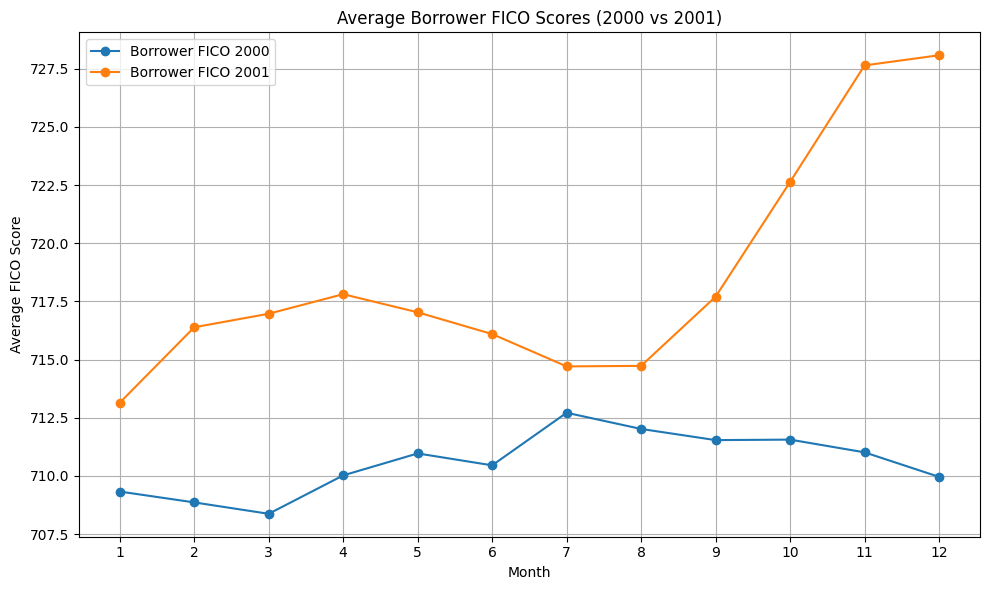

In [89]:
# Plot Borrower FICO Scores
plt.figure(figsize=(10, 6))
plt.plot(borrower_fico_2000_pd['Month'], borrower_fico_2000_pd['Avg_Borrower_FICO_2000'], label='Borrower FICO 2000', marker='o')
plt.plot(borrower_fico_2001_pd['Month'], borrower_fico_2001_pd['Avg_Borrower_FICO_2001'], label='Borrower FICO 2001', marker='o')
plt.title('Average Borrower FICO Scores (2000 vs 2001)')
plt.xlabel('Month')
plt.ylabel('Average FICO Score')
plt.legend()
plt.grid(True)
plt.xticks(borrower_fico_2000_pd['Month'])
plt.tight_layout()
plt.show()

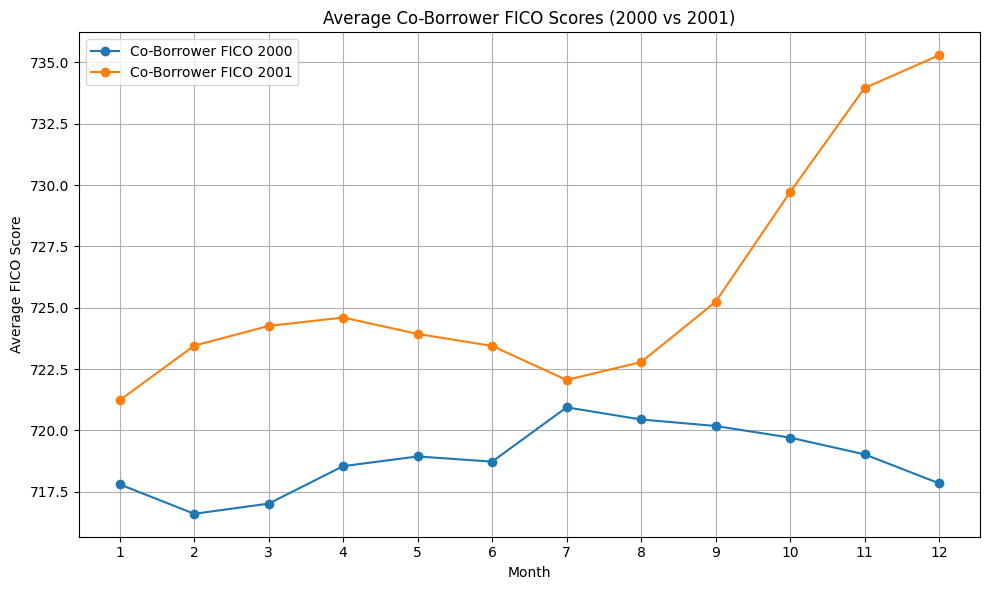

In [90]:
# Plot Co-Borrower FICO Scores
plt.figure(figsize=(10, 6))
plt.plot(coborrower_fico_2000_pd['Month'], coborrower_fico_2000_pd['Avg_CoBorrower_FICO_2000'], label='Co-Borrower FICO 2000', marker='o')
plt.plot(coborrower_fico_2001_pd['Month'], coborrower_fico_2001_pd['Avg_CoBorrower_FICO_2001'], label='Co-Borrower FICO 2001', marker='o')
plt.title('Average Co-Borrower FICO Scores (2000 vs 2001)')
plt.xlabel('Month')
plt.ylabel('Average FICO Score')
plt.legend()
plt.grid(True)
plt.xticks(coborrower_fico_2000_pd['Month'])
plt.tight_layout()
plt.show()

### Interpretation of Results

Borrowers and co-borrowers in 2001 had better credit scores compared to 2000, with a significant increase in both categories by the end of 2001.

Both borrower and co-borrower FICO scores see a sharp rise in October-December 2001, suggesting that either higher credit score borrowers were entering the market, or lending criteria became more selective toward the end of the year.

## 2) The monthly delinquency rates for 30, 60 and 90 days past due and how they vary by loan term

Calculating the monthly delinquency rates for loans that are 30, 60, and 90 days past due for loans originated in 2000 and 2001. Utilizing 'Origination Date' and 'Monthly Reporting Period'.

Formula Used: Delinquency Rate = (number of delinquent loans / total loans) * 100

In [59]:
# Filtering loans originated in 2000 and 2001 and ensure the Monthly Reporting Period is also in 2000 or 2001
filtered_loans = df_2000.union(df_2001).filter(
    (year("Origination Date").isin([2000, 2001])) &
    (year("Monthly Reporting Period").isin([2000, 2001]))
)

In [60]:
# Calculating the total number of loans for each month (without grouping by loan term)
total_loans = filtered_loans.groupBy(
    year("Monthly Reporting Period").alias("Year"),
    month("Monthly Reporting Period").alias("Month")
).agg(
    count("*").alias("Total_Loans")
)

In [61]:
# Calculating the delinquency rates for 30, 60, and 90 days past due (without grouping by loan term)
def calculate_delinquency_rate(filtered_loans, delinquency_code, days_past_due):
    """
    This function calculates the monthly delinquency rate for loans that are 30, 60, or 90 days past due.
    It groups the data by year and month and calculates the total number of delinquent loans.
    """
    delinquent_loans = filtered_loans.filter(col("Current Loan Delinquency Status") == delinquency_code)

    # Group by year and month and count the number of delinquent loans
    delinquency_rate = delinquent_loans.groupBy(
        year("Monthly Reporting Period").alias("Year"),
        month("Monthly Reporting Period").alias("Month")
    ).agg(
        count("*").alias(f"{days_past_due}_days_past_due_count")
    )

    return delinquency_rate

In [62]:
# Calculate delinquency rates for 30, 60, and 90 days past due
delinquency_30_days = calculate_delinquency_rate(filtered_loans, "01", 30)
delinquency_60_days = calculate_delinquency_rate(filtered_loans, "02", 60)
delinquency_90_days = calculate_delinquency_rate(filtered_loans, "03", 90)

In [63]:
# Join the total loans with the delinquency counts
delinquency_combined = total_loans.join(delinquency_30_days, ["Year", "Month"], "left") \
    .join(delinquency_60_days, ["Year", "Month"], "left") \
    .join(delinquency_90_days, ["Year", "Month"], "left")

In [64]:
# Calculate the delinquency rates as percentages for each month
delinquency_combined = delinquency_combined.withColumn(
    "30_days_past_due_rate", (col("30_days_past_due_count") / col("Total_Loans")) * 100
).withColumn(
    "60_days_past_due_rate", (col("60_days_past_due_count") / col("Total_Loans")) * 100
).withColumn(
    "90_days_past_due_rate", (col("90_days_past_due_count") / col("Total_Loans")) * 100
)

In [65]:
# Select relevant columns and sort by year and month
delinquency_combined = delinquency_combined.select(
    "Year", "Month", "Total_Loans",
    "30_days_past_due_rate", "60_days_past_due_rate", "90_days_past_due_rate"
).orderBy("Year", "Month")

In [66]:
# Show the overall results by month
delinquency_combined.show(100, truncate=False)

+----+-----+-----------+---------------------+---------------------+---------------------+
|Year|Month|Total_Loans|30_days_past_due_rate|60_days_past_due_rate|90_days_past_due_rate|
+----+-----+-----------+---------------------+---------------------+---------------------+
|2000|1    |5506       |NULL                 |NULL                 |NULL                 |
|2000|2    |88578      |0.0429000429000429   |NULL                 |NULL                 |
|2000|3    |227602     |0.5289935940808956   |0.001757453800933208 |NULL                 |
|2000|4    |388876     |0.7051090836153427   |0.04783015665662062  |5.143027597486089E-4 |
|2000|5    |567596     |0.7396105680801134   |0.06166357761506424  |0.011980352222355337 |
|2000|6    |760500     |0.7602892833662065   |0.07600262984878368  |0.01972386587771203  |
|2000|7    |967368     |0.8530362798852144   |0.08745379214528494  |0.023775853656519547 |
|2000|8    |1194450    |0.8378751726736154   |0.08941353761145297  |0.027460337393779566 |

In [92]:
# Convert the Spark DataFrame to Pandas for easier plotting
delinquency_pd = delinquency_combined.toPandas()

In [93]:
# Combine Year and Month into a single string for X-axis labeling
delinquency_pd['Year_Month'] = delinquency_pd['Year'].astype(str) + '-' + delinquency_pd['Month'].astype(str)

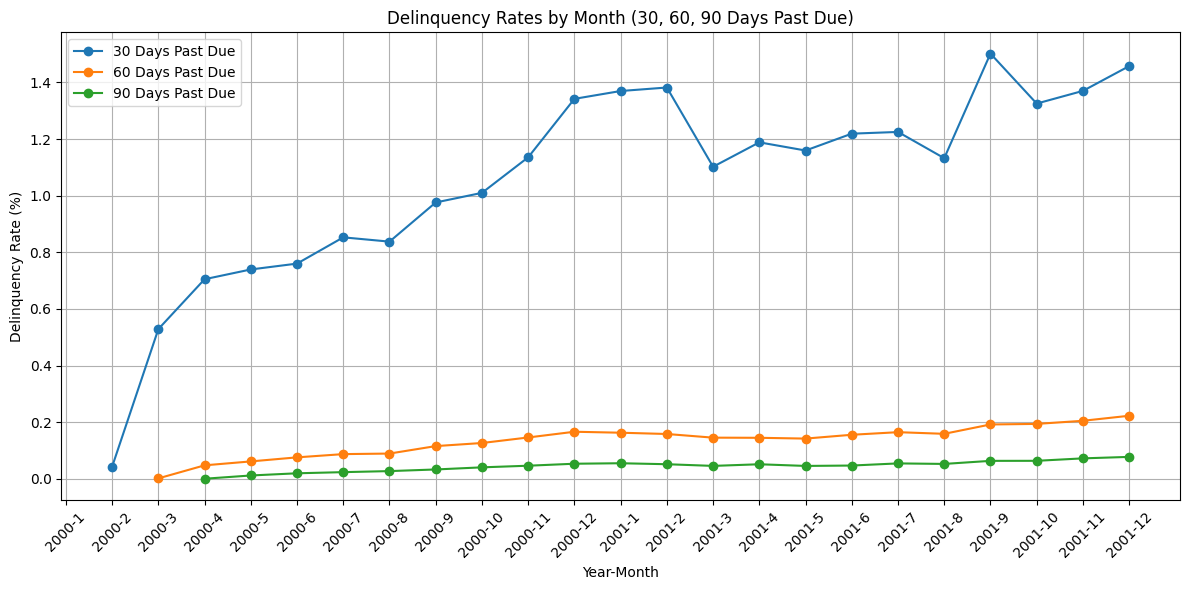

In [94]:
# Plot the delinquency rates for 30, 60, and 90 days past due
plt.figure(figsize=(12, 6))

# Plotting 30 days past due rate
plt.plot(delinquency_pd['Year_Month'], delinquency_pd['30_days_past_due_rate'], label='30 Days Past Due', marker='o')

# Plotting 60 days past due rate
plt.plot(delinquency_pd['Year_Month'], delinquency_pd['60_days_past_due_rate'], label='60 Days Past Due', marker='o')

# Plotting 90 days past due rate
plt.plot(delinquency_pd['Year_Month'], delinquency_pd['90_days_past_due_rate'], label='90 Days Past Due', marker='o')

# Customize the plot
plt.title('Delinquency Rates by Month (30, 60, 90 Days Past Due)')
plt.xlabel('Year-Month')
plt.ylabel('Delinquency Rate (%)')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

### Interpretation of Results

The rising delinquency rates for 30-day and 60-day past-due loans from 2000 to 2001 suggest that borrowers faced increasing difficulties making payments over time.
The 30-day delinquency rate in particular shows a consistent upward trend, indicating short-term financial struggles among borrowers.


## 3) Stacked bar chart showing the poor, fair good, very good, and excellent credit score with a mortgage per state for first time buyers.

In [95]:
# Filter the data for first-time homebuyers
first_time_buyers = df_2000.union(df_2001).filter(col("First Time Home Buyer Indicator") == "Y")

In [96]:
# Categorize credit scores into different categories (poor, fair, good, very good, excellent)
first_time_buyers = first_time_buyers.withColumn(
    "Credit Category",
    when(col("Borrower Credit Score at Origination") < 580, "Poor")
    .when((col("Borrower Credit Score at Origination") >= 580) & (col("Borrower Credit Score at Origination") <= 669), "Fair")
    .when((col("Borrower Credit Score at Origination") >= 670) & (col("Borrower Credit Score at Origination") <= 739), "Good")
    .when((col("Borrower Credit Score at Origination") >= 740) & (col("Borrower Credit Score at Origination") <= 799), "Very Good")
    .when(col("Borrower Credit Score at Origination") >= 800, "Excellent")
)

In [97]:
# Group the data by state and credit category and count the number of loans
credit_distribution_by_state = first_time_buyers.groupBy("Property State", "Credit Category").agg(count("*").alias("Count"))

In [162]:
# Remove any rows with null values to ensure clean data
credit_distribution_by_state = credit_distribution_by_state.na.drop()


In [163]:
# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
credit_distribution_by_state_pd = credit_distribution_by_state.toPandas()

In [164]:
# Pivot the data to get credit categories as columns for each state
credit_distribution_pivot = credit_distribution_by_state_pd.pivot(index="Property State", columns="Credit Category", values="Count").fillna(0)

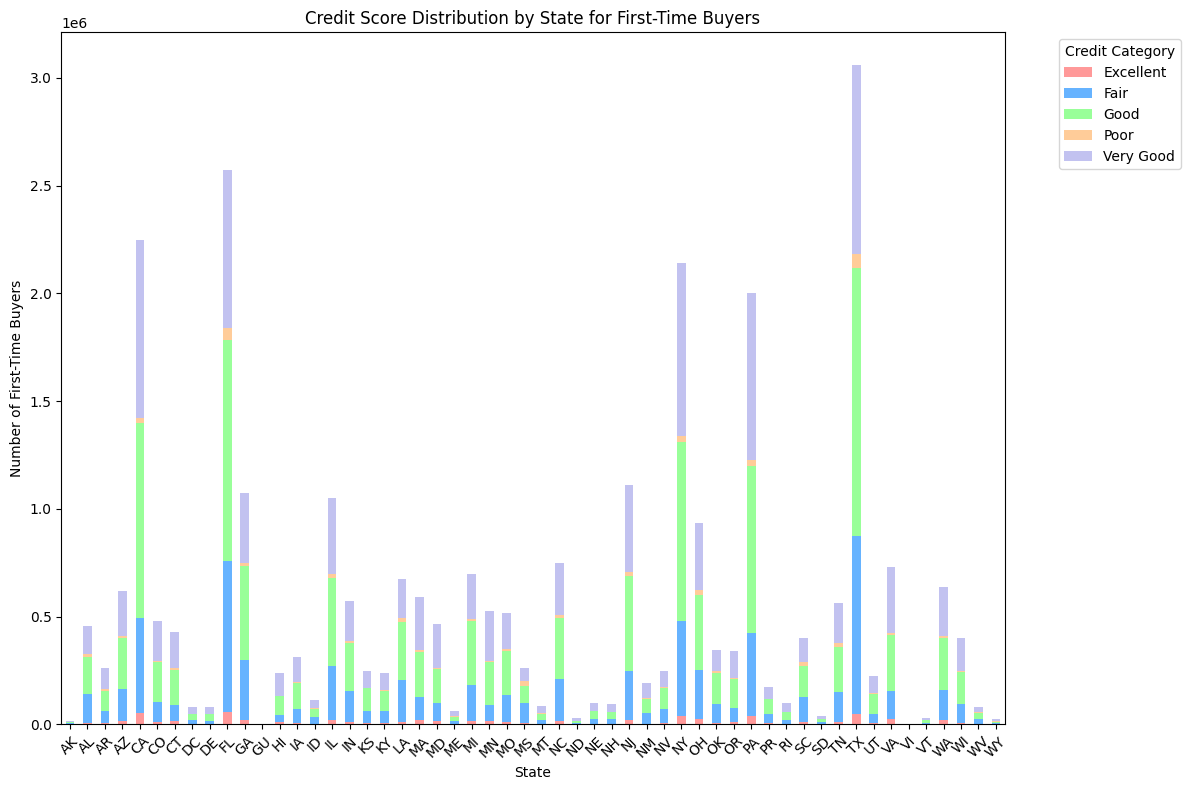

In [165]:
# Plot the stacked bar chart
credit_distribution_pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 8),
    color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']
)

# Adding labels and title
plt.title("Credit Score Distribution by State for First-Time Buyers")
plt.xlabel("State")
plt.ylabel("Number of First-Time Buyers")
plt.legend(title="Credit Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# Adjust layout to fit everything properly
plt.tight_layout()

# Show the plot
plt.show()

### Interpretation of the Results

Very Good and Good credit score categories dominate the first-time buyer market in most states.

low proportion of buyers with Excellent credit indicates that only a minority are in the top tier of creditworthiness.

Larger states like California, Texas, and Florida have much larger populations of first-time buyers, which could be reflective of their housing market size and population growth rates.

## Pre-processing for Analyis 4 and 5

In [104]:
# Select relevant columns: Borrower Credit Score, LTV Ratio, Interest Rate, and Loan Status
df_filtered = df_2000.union(df_2001).select(
    col("Borrower Credit Score at Origination").cast(DoubleType()).alias("FICO_Score"),
    col("Original Loan to Value Ratio (LTV)").cast(DoubleType()).alias("LTV_Ratio"),
    col("Original Interest Rate").cast(DoubleType()).alias("Interest_Rate"),
    col("Current Loan Delinquency Status").cast(IntegerType()).alias("Loan_Status")
)

In [118]:
# Remove any rows with null values to ensure clean data
df_filtered = df_filtered.na.drop()

In [111]:
# the chunk size (number of rows to process in each chunk)
chunk_size = 100000

In [112]:
# Processing in chunks to avoid memory issues
pandas_chunks = []
for start in range(0, total_rows, chunk_size):
    # Collect a chunk of data into Pandas
    chunk_df = df_filtered.limit(chunk_size).offset(start).toPandas()
    pandas_chunks.append(chunk_df)

In [113]:
# Combining the processed chunks into a single Pandas DataFrame
df_pandas = pd.concat(pandas_chunks, ignore_index=True)

## 4) Analyze correlations between the FICO Score, LTV Ratio, and Interest Rate with the loan status.

In [109]:
# Get the total number of rows in the filtered DataFrame
total_rows = df_filtered.count()

In [114]:
# Compute the correlation matrix
correlation_matrix = df_pandas.corr()

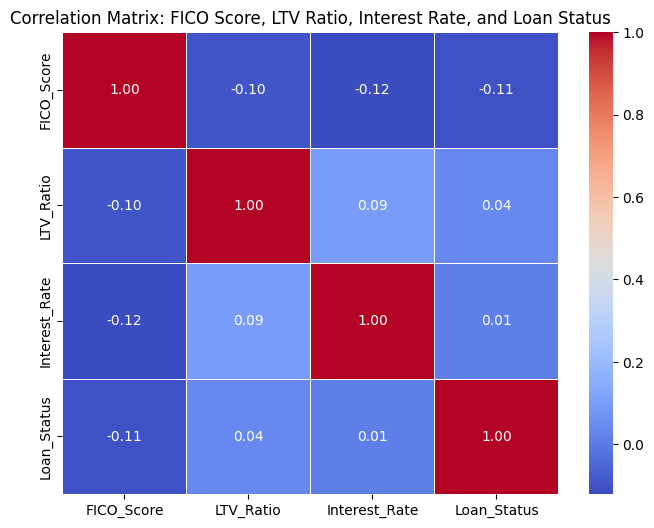

In [117]:
# Plot the correlation matrix as a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix: FICO Score, LTV Ratio, Interest Rate, and Loan Status')
plt.show()

### Interpretation of Results

The values in the heatmap range between -1 and 1, where:

1. 1 (or close to it) indicates a strong positive correlation.
2. -1 (or close to it) indicates a strong negative correlation.
3. 0 indicates no correlation.

Observations:
1. FICO Score and Loan Status Correlation: -0.11 (Weak Negative)

As the FICO Score increases, the loan status tends to improve. However, the relationship is not strong, which means that other features are also affecting loan status.

2. LTV Ratio and Loan Status Correlation: 0.04 (Very Weak Positive)

It means that higher LTV ratios (riskier loans) slightly increase the likelihood of delinquency, but it's effect is negligible in our data.

3. Interest Rate and Loan Status Correlation: 0.01 (Not Significant)

It means that interest rate levels do not predict whether a loan will become delinquent or not.

4. FICO Score and LTV Ratio Correlation: -0.10 (Weak Negative)

It means that higher FICO scores are generally associated with lower LTV ratios, but the relationship between them is weak in our data.

5. FICO Score and Interest Rate Correlation: -0.12 (Weak Negative)

Higher FICO scores usually tend to correlate with slightly lower interest rates. However, this relationship in our data is not very strong.

6. LTV Ratio and Interest Rate Correlation: 0.09 (Weak Positive)

It means that loans with higher LTV ratios tend to have slightly higher interest rates.

## 5) Distribution of FICO Scores, LTV Ratios, and Interest Rates across different loan statuses (performing, delinquent, defaulted).

In [128]:
# Assuming that loan status is categorized as:
# 0 = Performing, 1 = Delinquent (30+ days past due), 2 = Defaulted (more than 90 days past due)
df_pandas['Loan_Status_Category'] = df_pandas['Loan_Status'].apply(lambda x: 'Performing' if x == 0
                                                           else 'Delinquent' if x > 0 and x <= 90
                                                           else 'Defaulted')

 Plotting the distributions of FICO Score, LTV Ratio, and Interest Rate across loan statuses

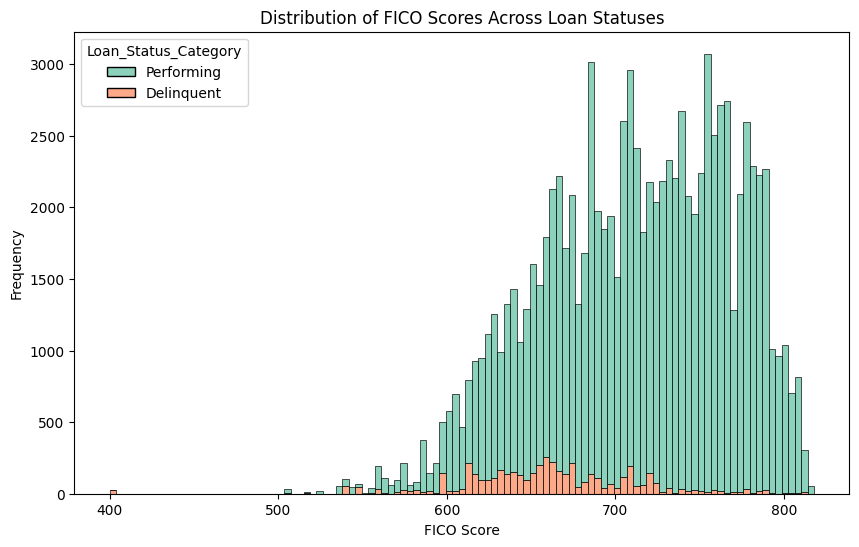

In [129]:
# FICO Score Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_pandas, x="FICO_Score", hue="Loan_Status_Category", multiple="stack", palette="Set2")
plt.title('Distribution of FICO Scores Across Loan Statuses')
plt.xlabel('FICO Score')
plt.ylabel('Frequency')
plt.show()



### Interpretation for FICO Score Distribution across Loan Statuses

Higher FICO scores (>700) are predominantly associated with performing loans, which indicates that borrowers with good credit are less likely to default on their loans.

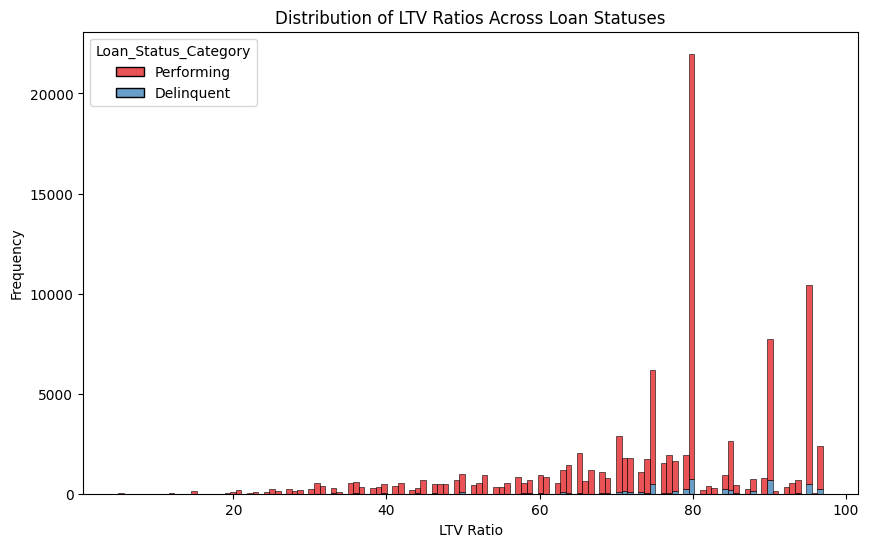

In [130]:
# LTV Ratio Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_pandas, x="LTV_Ratio", hue="Loan_Status_Category", multiple="stack", palette="Set1")
plt.title('Distribution of LTV Ratios Across Loan Statuses')
plt.xlabel('LTV Ratio')
plt.ylabel('Frequency')
plt.show()

### Interpretation for LTV Ratios Distribution across Loan Statuses

The LTV ratio plays a role in determining loan performance, with higher LTV ratios being slightly more likely to be delinquent.

Loans with an LTV ratio close to or above 80% have a higher risk of delinquency, but many of these loans are still performing.

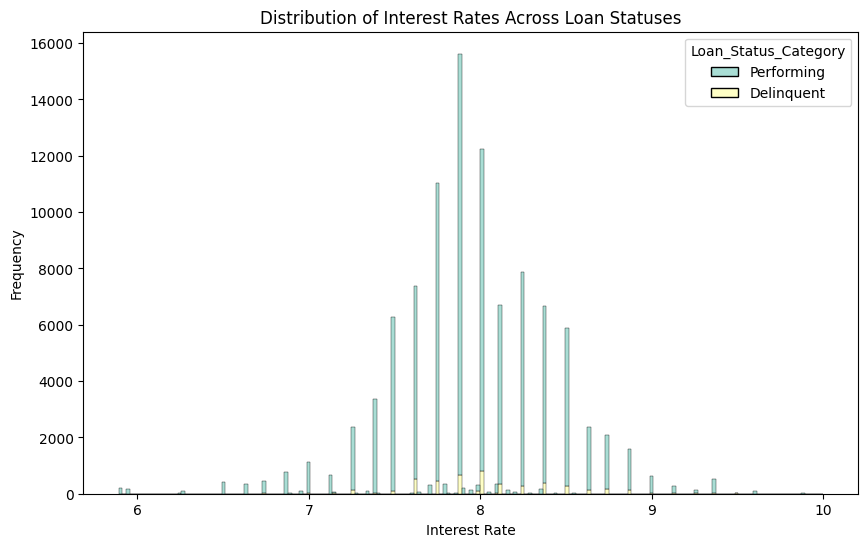

In [131]:
# Interest Rate Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_pandas, x="Interest_Rate", hue="Loan_Status_Category", multiple="stack", palette="Set3")
plt.title('Distribution of Interest Rates Across Loan Statuses')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.show()

### Interpretation for Interest Rates Distribution across Loan Statuses

Performing Loans dominate the distribution, particularly around the 8% interest rate mark, which appears to be the most common interest rate for performing loans whereas Delinquent Loans (yellow) are present but in much smaller numbers across the interest rate spectrum. However, they are visible at various interest rates.



## Compare default rates for loans originated in different quarters to assess if default risk has changed over time.

Formula used:

Default Rate = (Defaulted Loans / Total Loans) * 100

In [132]:
# Filtering the dataset for loans originated in the years 2000 and 2001
df_filtered = df_2000.union(df_2001).select(
    col("Origination Date"),
    col("Current Loan Delinquency Status").cast("int").alias("Delinquency_Status")
)

In [139]:
# Adding filter to include only loans originated in 2000 and 2001
df_filtered = df_filtered.filter((year("Origination Date") == 2000) | (year("Origination Date") == 2001))

In [140]:
# Creating a new column for the quarter of the Origination Date
df_filtered = df_filtered.withColumn("Origination_Year", year("Origination Date")) \
                         .withColumn("Origination_Quarter", quarter("Origination Date"))


In [141]:
# Defining the default status (using 90+ days delinquent as a proxy for default)
df_filtered = df_filtered.withColumn("Default_Status", when(col("Delinquency_Status") >= 90, 1).otherwise(0))

In [142]:
# Group by Origination Year and Quarter, and calculate the default rate
default_rate_by_quarter = df_filtered.groupBy("Origination_Year", "Origination_Quarter") \
    .agg(
        count("*").alias("Total_Loans"),
        count(when(col("Default_Status") == 1, True)).alias("Defaulted_Loans")
    ) \
    .withColumn("Default_Rate", (col("Defaulted_Loans") / col("Total_Loans")) * 100) \
    .orderBy("Origination_Year", "Origination_Quarter")

In [143]:
# Show the results of the default rates by quarter
default_rate_by_quarter.show()

+----------------+-------------------+-----------+---------------+--------------------+
|Origination_Year|Origination_Quarter|Total_Loans|Defaulted_Loans|        Default_Rate|
+----------------+-------------------+-----------+---------------+--------------------+
|            2000|                  1|   15339080|            526|0.003429149596977133|
|            2000|                  2|   17133812|            762|0.004447346568294...|
|            2000|                  3|   18754894|            928|0.004948041828442219|
|            2000|                  4|   22001660|           1724|0.007835772391719533|
|            2001|                  1|   49340522|           1970|0.003992661447724...|
|            2001|                  2|   63746284|           2014|0.003159399848311158|
|            2001|                  3|   52416376|           1984|0.003785076633302539|
|            2001|                  4|   50559500|           1162|0.002298282221936...|
+----------------+--------------

### Interpretation of Results

2000 shows a steady rise in default rates, peaking in Q4 2000 with a default rate of 0.0078%.

2001 shows more fluctuations in default rates across quarters, with a drop in defaults by Q4 2001.

The overall default rates are very low, indicating a stable loan portfolio with minimal risk of default during these years.


## The percentage of the loan amount recovered after default, through foreclosure or other means.

Formula used:

Recovery Percentage = (Total_Recovered_Amount/ Original_Loan_Amount) * 100

In [144]:
# Filtering for defaulted loans (where delinquency status is 90+ days past due)
df_defaulted = df_2000.union(df_2001).select(
    col("Original UPB").alias("Original_Loan_Amount"),  # UPB = Unpaid Principal Balance
    col("Net Sales Proceeds").cast("double").alias("Net_Sales_Proceeds"),
    col("Other Foreclosure Proceeds").cast("double").alias("Other_Foreclosure_Proceeds"),
    col("Credit Enhancement Proceeds").cast("double").alias("Credit_Enhancement_Proceeds"),
    col("Current Loan Delinquency Status").alias("Delinquency_Status")
).filter(col("Delinquency_Status") >= 90)  # Filter for loans 90+ days past due

In [145]:
# Calculating the total recovered amount by summing relevant fields
df_defaulted = df_defaulted.withColumn(
    "Total_Recovered_Amount",
    (col("Net_Sales_Proceeds") + col("Other_Foreclosure_Proceeds") + col("Credit_Enhancement_Proceeds"))
)

In [146]:
# Calculating the percentage of loan amount recovered
df_defaulted = df_defaulted.withColumn(
    "Recovery_Percentage",
    (col("Total_Recovered_Amount") / col("Original_Loan_Amount")) * 100
)

In [149]:
# Aggregating to find the total recovered amount, original loan amount, and overall recovery percentage
recovery_summary = df_defaulted.agg(
    spark_sum("Original_Loan_Amount").alias("Total_Original_Loan_Amount"),
    spark_sum("Total_Recovered_Amount").alias("Total_Recovered_Amount")
)

In [150]:
# Calculating the overall recovery percentage
recovery_summary = recovery_summary.withColumn(
    "Overall_Recovery_Percentage",
    (col("Total_Recovered_Amount") / col("Total_Original_Loan_Amount")) * 100
)

In [151]:
# Show the results
recovery_summary.show()

+--------------------------+----------------------+---------------------------+
|Total_Original_Loan_Amount|Total_Recovered_Amount|Overall_Recovery_Percentage|
+--------------------------+----------------------+---------------------------+
|                1.495784E9|    3755804.9400000004|        0.25109273397763315|
+--------------------------+----------------------+---------------------------+



### Interpretation of Results

The percentage of the loan amount recovered after default, through foreclosure or other
means is 25%.

## Plot average, median, and variance of property price changes over the entire duration, bucketed by month.

In [153]:
# Extracting relevant columns and filter data for the years 2000 and 2001
df_filtered = df_2000.union(df_2001).select(
    col("Origination Date"),
    col("Original UPB").alias("Property_Price")
).filter((year("Origination Date") == 2000) | (year("Origination Date") == 2001))

In [154]:
# Extracting the year and month from the Origination Date to group by month
df_filtered = df_filtered.withColumn("Year", year("Origination Date")) \
                         .withColumn("Month", month("Origination Date"))

In [155]:
# Grouping by Year and Month to calculate the average, median, and variance of property prices
# Calculating average and variance
df_stats = df_filtered.groupBy("Year", "Month") \
    .agg(
        avg("Property_Price").alias("Avg_Price"),  # Calculate average price
        expr("percentile_approx(Property_Price, 0.5)").alias("Median_Price"),  # Approximate median using percentile
        variance("Property_Price").alias("Price_Variance")  # Calculate variance of prices
    ).orderBy("Year", "Month")

In [156]:
# Show the results of property price statistics by month
df_stats.show()

+----+-----+------------------+------------+--------------------+
|Year|Month|         Avg_Price|Median_Price|      Price_Variance|
+----+-----+------------------+------------+--------------------+
|2000|    1| 105958.1947526345|     95000.0|3.0578035667346096E9|
|2000|    2|103057.10908405941|     91000.0| 3.002072155834855E9|
|2000|    3|103529.57059105946|     92000.0|3.0209300209921565E9|
|2000|    4|104884.03343646055|     95000.0| 3.034724075309117E9|
|2000|    5|105505.27391961469|     95000.0|3.1295987367874813E9|
|2000|    6|107357.44415536431|     97000.0| 3.221896417838266E9|
|2000|    7|109597.36484402874|    100000.0| 3.235605798921716E9|
|2000|    8|109649.48172078861|    100000.0| 3.270820206427249E9|
|2000|    9|110075.08398085221|    100000.0|  3.29909594050465E9|
|2000|   10|110106.75116588117|    100000.0|3.3018127926699047E9|
|2000|   11| 111673.7164542114|    100000.0|3.4006789252837687E9|
|2000|   12|115917.44348707552|    104000.0| 3.791424171678128E9|
|2001|    

In [157]:
# Converting to Pandas for plotting
df_stats_pd = df_stats.toPandas()

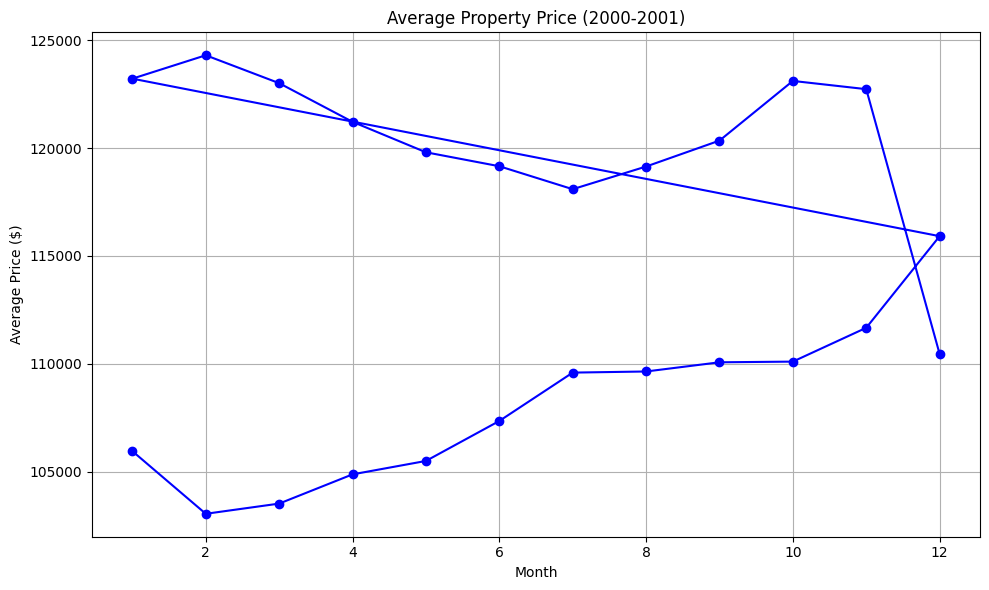

In [159]:
# Plot 1: Average Property Price
plt.figure(figsize=(10, 6))
plt.plot(df_stats_pd['Month'], df_stats_pd['Avg_Price'], marker='o', label='Average Price', color='blue')
plt.title('Average Property Price (2000-2001)')
plt.xlabel('Month')
plt.ylabel('Average Price ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation of Results for Average Property Price

2000: The average price starts relatively low around $105,000 and gradually increases over the months, showing a steady rise until the end of the year.

2001: The average price begins at a higher level, peaking in February 2001 at $124,000, and then declines for the remainder of the year.

It means that the rising prices during 2000 suggest a growing housing market, while the decline in 2001 may indicate changes in the market such as cooling demand.

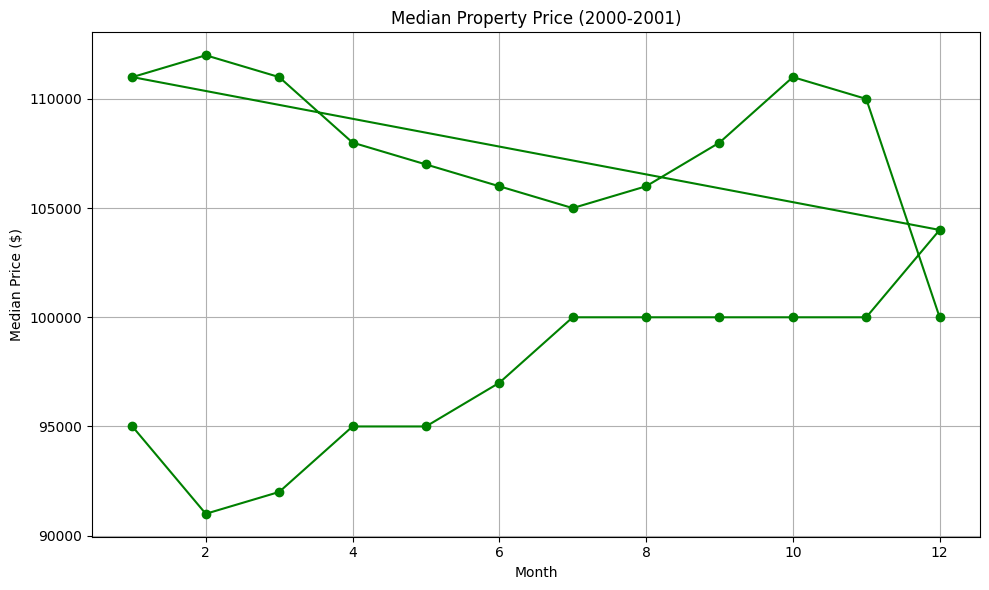

In [160]:
# Plot 2: Median Property Price
plt.figure(figsize=(10, 6))
plt.plot(df_stats_pd['Month'], df_stats_pd['Median_Price'], marker='o', label='Median Price', color='green')
plt.title('Median Property Price (2000-2001)')
plt.xlabel('Month')
plt.ylabel('Median Price ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation of Results for Median Property Price

Similar to the average, the median property price starts lower in 2000 (around $95,000), and increases throughout the year.

However, in 2001, the median price remains more stable, with a less pronounced peak in February 2001 before a moderate decline.

The median price being lower than the average in most months suggests that the distribution of property prices is skewed, with higher-priced properties pulling up the average.

This means that the majority of properties are priced below the average, and a few high-value properties are driving the higher average.


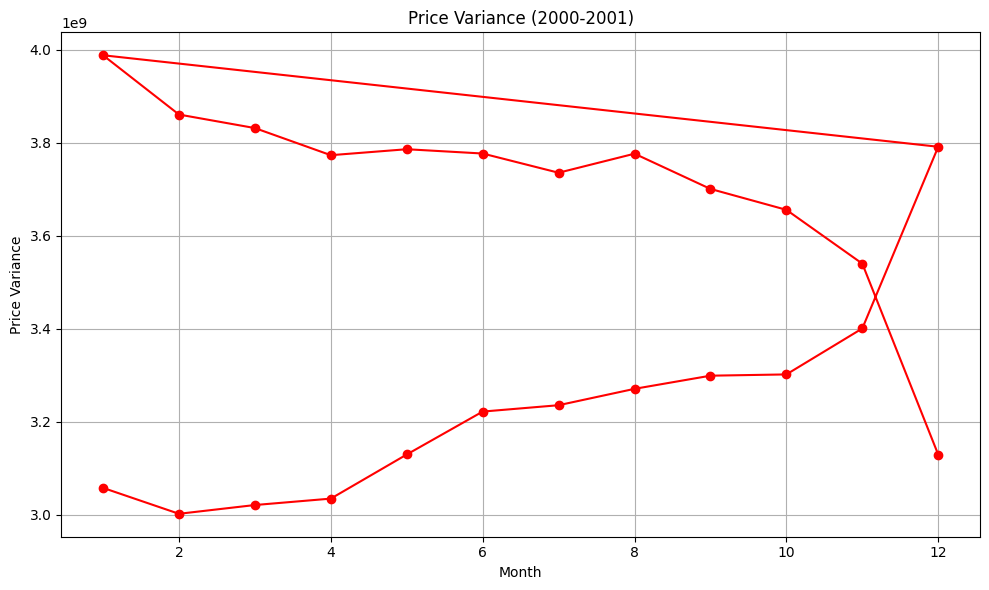

In [161]:
# Plot 3: Price Variance
plt.figure(figsize=(10, 6))
plt.plot(df_stats_pd['Month'], df_stats_pd['Price_Variance'], marker='o', label='Price Variance', color='red')
plt.title('Price Variance (2000-2001)')
plt.xlabel('Month')
plt.ylabel('Price Variance')
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation of Results for Price Variance

The high variance in property prices indicates a broad range of property values, with some properties priced significantly higher than others.

The decline in variance toward the end of 2001 suggests that property prices may be becoming more homogeneous, with less variation between high-end and low-end properties.